For this analysis I will do a Direct Multi-step forecast for the next 15/30 days.

I will test a variety of models that will run for each Nth day to find out what is the optimal model. There will be no parameter tuning.

In [1]:
import pyodbc
import sqlalchemy
import pandas as pd
import numpy as np
import json
from datetime import datetime as dt
from datetime import timedelta
from matplotlib import pyplot as plt
from pylab import rcParams
%matplotlib inline

In [2]:
# server connection

with open(f'/Users/terrill/Documents/work/stuff/spy_trend/sql_server_info_equities.txt', 'r') as f:
    line = f.readline().split(',')
name, user, password = line[0], line[3], line[4]

sqlalchemy.create_engine(f'mssql+pyodbc://{user}:{password}@{name}')
%load_ext sql
%sql mssql+pyodbc://$user:$password@$name
%config SqlMagic.displaycon = False

<h5>Cleaning up Yahoo data</h5>

In [3]:
def clean_yahoo_df(df, ticker):
    df.drop(['HighPrice','LowPrice','OpenPrice'], axis=1, inplace=True)
    df = df.astype({'ClosePrice': 'float'})
    df['ClosePrice'] = df['ClosePrice'].round(2)
    #df['Volume'] = df['Volume'].astype('int32')
    df.rename(columns={'Volume': f'{ticker}_Volume', 'ClosePrice': ticker}, inplace=True)
    df.set_index('Date', inplace=True)
    
    return df

In [4]:
%%capture

main_df = %sql select * from equities.dbo.spy order by date

main_df = clean_yahoo_df(main_df.DataFrame(), 'SPY')

In [5]:
main_df.tail()

,SPY,SPY_Volume
Date,,
2020-06-26,300.05,127961000
2020-06-29,304.46,79773300
2020-06-30,308.36,113394800
2020-07-01,310.52,72396500
2020-07-02,312.23,69344200


A few economic indicators are updated weekly, monthly, etc. Some of those days are on the weekend when equity markets are not opened. For that, we will have to outer join those dataframes with the main dataframes, forward fill the NaN data, and remove weekend dates. Below is the list of SPY dates that will be used later.

In [6]:
spy_dates = list(main_df.index)

Below are all tickers pulled from Yahoo and saved locally. I will need to find a way to automate the refresh daily but for now will use the data I have to optimize the model.

Also note, for the individual sector ETFs, I will use Vanguard ETFs instead of SPDR even if SPY is an SPDR ETFs. Even though most of the SPDR ETFs are larger and more liquid I find the Vanguard ETFs more accurately reflects their respective idustries as the portfolios include small and mid caps. SPDR ETFs are heavily concentrated in stocks already included in SPY.

In [7]:
etfs = ['QQQ', 'IWM', 'TLT', 'IEF', 'VNQ', 'VGT', 'VHT', 'VFH', 'VCR', 'VIS', 'VDC', 'VPU', 'VDE', 'VAW', 'VOX']

futures = ['CL=F', 'GC=F', 'SI=F', 'ZF=F', 'ZN=F']

In [8]:
%%capture

for ticker in etfs:
    query = %sql SELECT * FROM Equities.dbo.$ticker ORDER BY date DESC
    temp_df = clean_yahoo_df(query.DataFrame(), ticker)
    main_df = main_df.join(temp_df, how='left')

for ticker in futures:
    new_ticker = ticker.replace('=','_')
    query = %sql SELECT * FROM Futures.dbo.$new_ticker ORDER BY date DESC
    temp_df = clean_yahoo_df(query.DataFrame(), ticker)
    main_df = main_df.join(temp_df, how='left')

In [9]:
main_df.tail(3)

,SPY,SPY_Volume,QQQ,QQQ_Volume,IWM,IWM_Volume,TLT,TLT_Volume,IEF,IEF_Volume,...,CL=F,CL=F_Volume,GC=F,GC=F_Volume,SI=F,SI=F_Volume,ZF=F,ZF=F_Volume,ZN=F,ZN=F_Volume
Date,,,,,,,,,,,,,,,,,,,,,
2020-06-30,308.36,113394800,247.60,38909200.0,143.18,32865900.0,163.74,14841700.0,121.76,4126700.0,...,39.66,143721086.0,1800.4,87426446.0,18.60,27498487.0,125.74,222311932.0,139.16,436197367.0
2020-07-01,310.52,72396500,250.49,34689200.0,141.82,26457500.0,163.42,13181000.0,121.57,8416500.0,...,39.61,171886332.0,1778.3,128714431.0,18.26,40526778.0,125.60,247177437.0,138.94,524020934.0
2020-07-02,312.23,69344200,252.19,31956500.0,142.40,24022400.0,163.59,7599800.0,121.72,3054100.0,...,40.32,130102415.0,1787.1,89155862.0,18.25,21540289.0,125.73,175910173.0,139.16,405103512.0


<h5>Other charts (Treasure bond yields, Libor rate, Mortgage rate, M1 & M2 money supply, VIX, DIX)</h5>
<br>
Data pulled from various sources.

In [10]:
# maybe include VVIX in the future?
# Notes:
# 30 year fixed mortgage rate is updated monthly (need may numbers)
# money supply data is updated weekly

economics_tickers = ['CPIAUCSL', 'DFF', 'DGS10', 'DGS30', 'M1', 'M2', 'MORTGAGE15US', 'MORTGAGE30US',
                     'T10YIE', 'USD1MTD156N', 'USD6MTD156N', 'USD12MD156N']
economic_names = ['CPI', 'Fed_Funds_Rate', '10_yr_Treasury', '30_yr_Treasury', 'M1_Supply',
                  'M2_Supply', '15_yr_Mortgage', '30_yr_Mortgage', '10_yr_Inflation',
                  '1m_Libor', '3m_Libor', '12m_Libor']
  #10_yr_Treasury, 30_yr_Treasury, 15_yr_Mortgage, 30_yr_Mortgage, 10_yr_Inflation, 1m_Libor, 3m_Libor, 12m_Libor
forex = ['USD_JPY', 'USD_EUR', 'USD_CHF', 'USD_PLN', 'USD_CNY', 'USD_HUF', 'USD_RUB', 'USD_CAD',
         'USD_RON', 'USD_INR', 'USD_GBP', 'USD_AUD', 'USD_HKD', 'USD_SEK', 'USD_SGD', 'XAU_USD',
         'DXY']

vix = 'I_VIX'
dix = 'DIX'

In [11]:
%%capture

# economics data
for ticker, name in zip(economics_tickers, economic_names):
    query = %sql SELECT * FROM Economics.dbo.$ticker WHERE Date >= '1993-01-01' ORDER BY date
    temp_df = query.DataFrame()
    temp_df.set_index('Date', inplace=True)
    temp_df.rename(columns={temp_df.columns[0]: name}, inplace=True)
    if ticker in ['M1', 'M2']:
        temp_df *= 1000000000
    temp_df = temp_df.astype({name: 'float'})
    main_df = main_df.join(temp_df, how='outer')

# forex
for ticker in forex:
    query = %sql SELECT * FROM Forex.dbo.$ticker WHERE Date >= '1993-01-01' ORDER BY date
    temp_df = query.DataFrame()
    temp_df.drop(['OpenPrice', 'HighPrice', 'LowPrice'], axis=1, inplace=True)
    temp_df = temp_df.astype({'ClosePrice': 'float'})
    temp_df['ClosePrice'] = temp_df['ClosePrice'].round(2)
    temp_df.set_index('Date', inplace=True)
    temp_df.rename(columns={'ClosePrice': ticker}, inplace=True)
    main_df = main_df.join(temp_df, how='left')

# vix
query = %sql SELECT * FROM Equities.dbo.I_VIX WHERE Date >= '1993-01-01' ORDER BY date
temp_df = query.DataFrame()
temp_df.drop(['HighPrice', 'LowPrice', 'OpenPrice'], axis=1, inplace=True)
temp_df = temp_df.astype({'ClosePrice': 'float'})
temp_df['ClosePrice'] = temp_df['ClosePrice'].round(2)
temp_df.set_index('Date', inplace=True)
temp_df.rename(columns={'ClosePrice': 'VIX'}, inplace=True)
main_df = main_df.join(temp_df, how='left')

# # dix (leaving this out for now)
# query = %sql SELECT * FROM Equities.dbo.I_DIX ORDER BY date
# temp_df = query.DataFrame()
# temp_df.drop(['SPX'], axis=1, inplace=True)
# temp_df = temp_df.astype({'DIX': 'float', 'GEX': 'float'})
# temp_df.set_index('Date', inplace=True)
# main_df = main_df.join(temp_df, how='left')

In [12]:
main_df.iloc[:,:].tail()

,SPY,SPY_Volume,QQQ,QQQ_Volume,IWM,IWM_Volume,TLT,TLT_Volume,IEF,IEF_Volume,...,USD_RON,USD_INR,USD_GBP,USD_AUD,USD_HKD,USD_SEK,USD_SGD,XAU_USD,DXY,VIX
Date,,,,,,,,,,,,,,,,,,,,,
2020-06-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-29,304.46,79773300.0,242.84,34377800.0,141.14,33935200.0,164.54,7274400.0,121.98,28632400.0,...,4.31,75.51,0.81,1.46,7.75,9.33,1.39,1772.28,97.54,31.78
2020-06-30,308.36,113394800.0,247.60,38909200.0,143.18,32865900.0,163.74,14841700.0,121.76,4126700.0,...,4.31,75.54,0.81,1.45,7.75,9.32,1.39,1781.67,97.39,30.43
2020-07-01,310.52,72396500.0,250.49,34689200.0,141.82,26457500.0,163.42,13181000.0,121.57,8416500.0,...,4.31,75.49,0.80,1.45,7.75,9.31,1.39,1770.31,97.20,28.62
2020-07-02,312.23,69344200.0,252.19,31956500.0,142.40,24022400.0,163.59,7599800.0,121.72,3054100.0,...,4.30,74.75,0.80,1.44,7.75,9.32,1.39,1776.14,97.32,27.68


Forward fill any data that is updated weekly, monthly, etc. Remove all dates when market is closed (weekends, holidays).

In [13]:
main_df.ffill(inplace=True)

In [14]:
main_df = main_df[main_df.index.isin(spy_dates)]
main_df.head(3)

,SPY,SPY_Volume,QQQ,QQQ_Volume,IWM,IWM_Volume,TLT,TLT_Volume,IEF,IEF_Volume,...,USD_RON,USD_INR,USD_GBP,USD_AUD,USD_HKD,USD_SEK,USD_SGD,XAU_USD,DXY,VIX
Date,,,,,,,,,,,,,,,,,,,,,
1993-01-29,26.18,1003200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,31.38,0.67,1.47,7.73,7.30,1.65,329.85,92.46,12.42
1993-02-01,26.37,480500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,31.42,0.69,1.48,7.74,7.46,1.65,329.85,93.56,12.33
1993-02-02,26.43,201300.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,31.62,0.69,1.47,7.74,7.44,1.65,329.65,93.92,12.25


<h5>Last Value Multi-Step Method</h5>
For the direct multi-step time forcasting we will be predicting the target price for the next 15 days. To do this we will be creating columns for each day, shifiting the adjusted closing price value up by (t-n) days.

<h5>Rolling Mean and Standard Deviation</h5>
To be used later to inverse scaled predictions. We will be adding a rolling mean and standard deviation to each of the forward looking days. (probably a more efficient method exists -- all means and std could be shifted up as well)

Note: The goal is to project prices 30 days in advanced but we will start with 15 for now.

In [15]:
# number of days to project in the future
days_to_predict = 30

for i in range(1, days_to_predict+1):
    main_df[f'target_SPY_{i}d'] = main_df['SPY'].shift(-i)
    main_df[f'SPY_mean_{i}d'] = main_df[f'target_SPY_{i}d'].rolling(window=5, min_periods=1).mean()
    main_df[f'SPY_std_{i}d'] = main_df[f'target_SPY_{i}d'].rolling(window=5, min_periods=1).std()
    
main_df.drop(main_df.tail(days_to_predict).index, inplace=True)
main_df.drop('SPY', axis=1, inplace=True)

In [16]:
main_df.tail(3)

,SPY_Volume,QQQ,QQQ_Volume,IWM,IWM_Volume,TLT,TLT_Volume,IEF,IEF_Volume,VNQ,...,SPY_std_27d,target_SPY_28d,SPY_mean_28d,SPY_std_28d,target_SPY_29d,SPY_mean_29d,SPY_std_29d,target_SPY_30d,SPY_mean_30d,SPY_std_30d
Date,,,,,,,,,,,,,,,,,,,,,
2020-05-18,120320200.0,227.04,42597600.0,132.23,47075400.0,162.65,10074000.0,120.97,3091200.0,72.16,...,3.077117,300.05,306.832,4.882594,304.46,305.600,4.445425,308.36,304.862,3.253424
2020-05-19,95189300.0,226.47,36237300.0,129.62,30270000.0,163.26,8639100.0,121.31,1941700.0,71.19,...,4.882594,304.46,305.600,4.445425,308.36,304.862,3.253424,310.52,306.148,4.046204
2020-05-20,85861700.0,230.99,37417000.0,133.55,35901300.0,163.75,10927300.0,121.34,2366700.0,71.82,...,4.445425,308.36,304.862,3.253424,310.52,306.148,4.046204,312.23,307.124,4.905867


<h5>Handling Null Values</h5>
<br>
I have decided to drop any rows with NaN. There are a few tickers that was created way after the SPY etf was created. Will experiment with removing a few of those tickers for the analysis.
<br>

In [17]:
# the first row without null values
main_df[~main_df.isnull().any(axis=1)].index[0]

datetime.date(2004, 9, 29)

In [18]:
main_df.isna().sum().sort_values(ascending=False).head(5)

VOX_Volume    2939
VNQ_Volume    2939
VOX           2939
VIS_Volume    2939
VIS           2939
dtype: int64

In [19]:
main_df = main_df.dropna(axis=0)
main_df.index = pd.to_datetime(main_df.index,format='%Y-%m-%d')
main_df.head()

,SPY_Volume,QQQ,QQQ_Volume,IWM,IWM_Volume,TLT,TLT_Volume,IEF,IEF_Volume,VNQ,...,SPY_std_27d,target_SPY_28d,SPY_mean_28d,SPY_std_28d,target_SPY_29d,SPY_mean_29d,SPY_std_29d,target_SPY_30d,SPY_mean_30d,SPY_std_30d
Date,,,,,,,,,,,,,,,,,,,,,
2004-09-29,33325700.0,30.60,95096200.0,45.90,16073200.0,52.10,1970700.0,55.54,226100.0,24.51,...,1.251771,85.15,84.268,1.161667,84.99,84.754,0.674707,85.05,85.044,0.197687
2004-09-30,43536700.0,30.65,74514600.0,45.90,17295400.0,51.90,1945700.0,55.48,175000.0,24.70,...,1.161667,84.99,84.754,0.674707,85.05,85.044,0.197687,85.70,85.234,0.282719
2004-10-01,62824300.0,31.49,118252700.0,47.05,16410000.0,51.64,1999300.0,55.26,270200.0,25.16,...,0.674707,85.05,85.044,0.197687,85.70,85.234,0.282719,86.37,85.452,0.585338
2004-10-04,33082400.0,31.67,108032600.0,47.32,13371200.0,51.72,1106200.0,55.28,278100.0,25.27,...,0.197687,85.70,85.234,0.282719,86.37,85.452,0.585338,86.59,85.740,0.734779
2004-10-05,36910600.0,31.72,89754400.0,47.27,10255200.0,51.72,501700.0,55.28,220000.0,25.26,...,0.282719,86.37,85.452,0.585338,86.59,85.740,0.734779,85.97,85.936,0.603722


<h5>Splitting data into train, validation, test sets</h5>

In [20]:
# validation size
valid_size = int(len(main_df) * 0.2)
train_size = len(main_df) - valid_size

train = main_df.iloc[:train_size - days_to_predict - 1].copy()
valid = main_df.iloc[train_size - days_to_predict - 1:train_size + valid_size - days_to_predict - 1].copy()
train_valid = main_df.iloc[:train_size + valid_size - days_to_predict - 1].copy()
test = main_df.iloc[-days_to_predict - 1].copy()
actual_results = main_df.iloc[-days_to_predict:].copy()

# set date ranges
# train: 2004-09-29:2017-03-29
# valid: 2017-03-30:2020-05-19
# train_valid: 2004-09-29:2020-05-19
# test: 2020-05-20
# predictions: 2020-05-21:2020-06-11

<h5>Normalizing Data</h5>

In [22]:
cols_to_normalize = ['SPY_Volume', 'QQQ', 'QQQ_Volume', 'IWM', 'IWM_Volume', 'TLT', 'TLT_Volume', 'IEF',
                     'IEF_Volume', 'VNQ', 'VNQ_Volume', 'VGT', 'VGT_Volume', 'VHT', 'VHT_Volume', 'VFH',
                     'VFH_Volume', 'VCR', 'VCR_Volume', 'VIS', 'VIS_Volume', 'VDC', 'VDC_Volume', 'VPU',
                     'VPU_Volume', 'VDE', 'VDE_Volume', 'VAW', 'VAW_Volume', 'VOX', 'VOX_Volume', 'CL=F',
                     'CL=F_Volume', 'GC=F', 'GC=F_Volume', 'SI=F', 'SI=F_Volume', 'ZF=F', 'ZF=F_Volume',
                     'ZN=F', 'ZN=F_Volume', 'CPI', 'M1_Supply', 'M2_Supply', 'USD_JPY', 'USD_CHF', 'USD_PLN',
                     'USD_CNY', 'USD_HUF', 'USD_RUB', 'USD_CAD', 'USD_RON', 'USD_INR', 'USD_AUD', 'USD_HKD',
                     'USD_SEK', 'USD_SGD', 'XAU_USD', 'DXY', 'VIX', 'target_SPY_1d', 'target_SPY_2d',
                     'target_SPY_3d', 'target_SPY_4d', 'target_SPY_5d', 'target_SPY_6d', 'target_SPY_7d',
                     'target_SPY_8d', 'target_SPY_9d', 'target_SPY_10d', 'target_SPY_11d', 'target_SPY_12d',
                     'target_SPY_13d', 'target_SPY_14d', 'target_SPY_15d', 'target_SPY_16d', 'target_SPY_17d',
                     'target_SPY_18d', 'target_SPY_19d', 'target_SPY_20d', 'target_SPY_21d', 'target_SPY_22d',
                     'target_SPY_23d', 'target_SPY_24d', 'target_SPY_25d', 'target_SPY_26d', 'target_SPY_27d',
                     'target_SPY_28d', 'target_SPY_29d', 'target_SPY_30d']

# cols_to_normalize = []
# for i in main_df.columns:
#     if main_df[i].max() >= 1 and ('mean' not in i and 'std' not in i):
#         cols_to_normalize.append(i)
# cols_to_normalize

In [23]:
from sklearn.preprocessing import StandardScaler

# scaling train data
scaler_train = StandardScaler()
train_scaled = scaler_train.fit_transform(train[cols_to_normalize])
train_scaled = pd.DataFrame(train_scaled, columns=cols_to_normalize, index=train.index)
train_scaled = train_scaled.join(train.loc[:, ~train.columns.isin(cols_to_normalize)])
train_scaled.shape

(3120, 161)

In [24]:
#scaling train_valid data
scaler_train_valid = StandardScaler()
train_valid_scaled = scaler_train_valid.fit_transform(train_valid[cols_to_normalize])
train_valid_scaled = pd.DataFrame(train_valid_scaled, columns=cols_to_normalize, index=train_valid.index)
train_valid_scaled = train_valid_scaled.join(train_valid.loc[:, ~train_valid.columns.isin(cols_to_normalize)])
train_valid_scaled.shape

(3907, 161)

In [25]:
# scaling valid data - separating target columns for another scaler object
# need to remove any target columns as well as any mean/std calculated columns
scaler_valid = StandardScaler()
valid_scaled = scaler_valid.fit_transform(valid[cols_to_normalize].drop(valid.filter(regex='target').columns, axis=1))
valid_scaled = pd.DataFrame(valid_scaled, columns=cols_to_normalize[:-days_to_predict], index=valid.index)
valid_scaled = valid_scaled.join(valid.loc[:, ~valid.columns.isin(cols_to_normalize)]
                                         .drop(valid.filter(regex='mean').columns, axis=1)
                                         .drop(valid.filter(regex='std').columns, axis=1))
valid_scaled.shape

(787, 71)

In [25]:
# normalize = (test[cols_to_normalize[:-15]] - test['SPY_mean_1d']) / test['SPY_std_1d']
# inverse = normalize * test['SPY_std_1d'] + test['SPY_mean_1d']

Normalizing the test set will have to be done manually as there will only be one observation. Using StandardScaler() will turn all numbers to zero.

Normalize the numbers by applying the below formula to the observations using the mean and standard deviation calculations according to the number of days to forecast. Above is an example.

eg... application and inverse<br>
z = (x - u) / s<br>
x = z * s + u

<h5>Splitting into X and y</h5>

In [27]:
features = [i for i in main_df.columns if 'target' not in i and 'mean' not in i and 'std' not in i]
target = [i for i in main_df.columns if 'target' in i]

In [28]:
# non-scaled data
X_train = train[features]
X_valid = valid[features]
X_train_valid = train_valid[features]
X_test = test[features]

y_train = train[target]
y_valid = valid[target]
y_train_valid = train_valid[target]
y_test = test[target]


print('Features')
print(f'X_train shape: {X_train.shape}')
print(f'X_valid shape: {X_valid.shape}')
print(f'X_train_valid shape: {X_train_valid.shape}')
print(f'X_test shape: {X_test.shape}')

print('\nTargets')
print(f'y_train shape: {y_train.shape}')
print(f'y_valid shape: {y_valid.shape}')
print(f'y_train_valid shape: {y_train_valid.shape}')
print(f'y_test shape: {y_test.shape}')

Features
X_train shape: (3120, 71)
X_valid shape: (787, 71)
X_train_valid shape: (3907, 71)
X_test shape: (71,)

Targets
y_train shape: (3120, 30)
y_valid shape: (787, 30)
y_train_valid shape: (3907, 30)
y_test shape: (30,)


<h5>Setting Up Models</h5>

In [29]:
# scaled data
X_train_scaled = train_scaled[features]
X_valid_scaled = valid_scaled[features]
X_train_valid_scaled = train_valid_scaled[features]

y_train_scaled = train_scaled[target]
y_train_valid_scaled = train_valid_scaled[target]

print(f'X_train_scaled shape: {X_train_scaled.shape}')
print(f'X_valid_scaled shape: {X_valid_scaled.shape}')
print(f'X_train_valid_scaled shape: {X_train_valid_scaled.shape}')

X_train_scaled shape: (3120, 71)
X_valid_scaled shape: (787, 71)
X_train_valid_scaled shape: (3907, 71)


<h5>Testing with the following algorithms below</h5>

Lars was removed because it was consistently under performing for all days.

In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import math


models = {}

models['linear_regression'] = LinearRegression()
models['lasso'] = Lasso(random_state=0)
models['ridge'] = Ridge(random_state=0)
models['sgd_regressor'] = SGDRegressor(random_state=0)
models['elastic_net'] = ElasticNet(random_state=0)
models['knn_regressor'] = KNeighborsRegressor()
models['svr'] = SVR()
models['decision_tree_regressor'] = DecisionTreeRegressor(random_state=0)
models['random_forest_regressor'] = RandomForestRegressor(random_state=0)
models['gradient_boost_regressor'] = GradientBoostingRegressor(random_state=0)
models['mlp_regressor'] = MLPRegressor(random_state=0)
models['xgboost'] = XGBRegressor(random_state=0)

<h5>Predicting with training set</h5>

In [30]:
# results of each model of each day
train_results = {}

for model in models:
    train_results[model] = {}

for name, model in models.items():
    train_results[name] = {}
    for day in range(1, days_to_predict+1):
#         print(name, day)
        model.fit(X_train_scaled, y_train_scaled[f'target_SPY_{day}d'])
        prediction = model.predict(X_train_scaled)
        prediction = prediction * train[f'SPY_std_{day}d'] + train[f'SPY_mean_{day}d']
        train_results[name][day] = prediction

In [31]:
# results['linear_regression']
# y_train['target_SPY_1d']
# X_train_scaled.columns

In [32]:
train_rmse_results = pd.DataFrame(index=range(1, days_to_predict+1))

for name in models.keys():
    rmse_per_day = []
    for day in range(1, days_to_predict+1):
        rmse_score = math.sqrt(mean_squared_error(y_train[f'target_SPY_{day}d'], train_results[name][i]))
        rmse_per_day.append(rmse_score)
    train_rmse_results[name] = rmse_per_day
    
train_rmse_results.head(2)

,linear_regression,lasso,ridge,sgd_regressor,elastic_net,knn_regressor,svr,decision_tree_regressor,random_forest_regressor,gradient_boost_regressor,mlp_regressor,xgboost
1,3.996762,3.670663,3.973885,3.963935,3.736228,4.044599,4.019035,4.077530,4.067354,4.03753,4.025491,4.075945
2,3.838066,3.509882,3.816683,3.807171,3.574825,3.883892,3.859806,3.915148,3.905599,3.87732,3.866749,3.913573


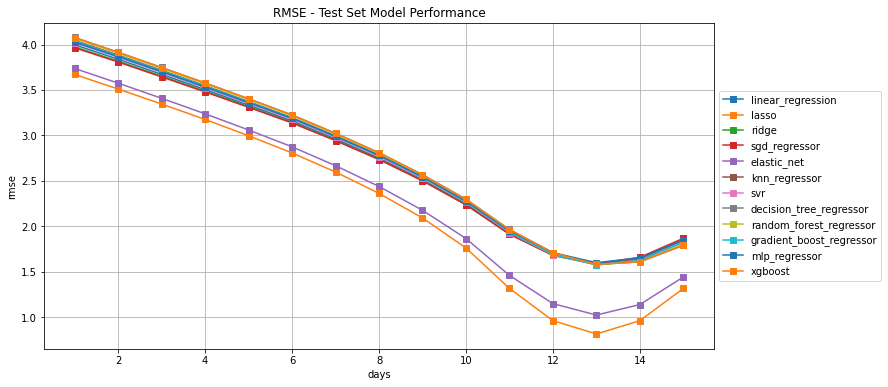

In [33]:
# # plotting results
rcParams['figure.figsize'] = 12, 6

legend_list = ['linear_regression']

ax = train_rmse_results['linear_regression'].plot(x='days', y='rmse', marker='s', grid=True)

for col in train_rmse_results.columns[1:]:
    ax = train_rmse_results[col].plot(x='x', y='rmse', marker='s', grid=True, ax=ax)
    legend_list.append(col)

ax.set_xlabel('days')
ax.set_ylabel('rmse')
ax.set_title('RMSE - Test Set Model Performance')
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.gcf().set_facecolor('white')

<h5>Predicting with validation set</h5>

In [34]:
valid_results = {}

for model in models:
    valid_results[model] = {}

for name, model in models.items():
    valid_results[name] = {}
    for day in range(1, days_to_predict+1):
#         print(name, day)
        model.fit(X_train_scaled, y_train_scaled[f'target_SPY_{day}d'])
        prediction = model.predict(X_valid_scaled)
        prediction = prediction * valid[f'SPY_std_{day}d'] + valid[f'SPY_mean_{day}d']
        valid_results[name][day] = prediction

In [35]:
# X_train_scaled.columns
# X_valid_scaled.columns

In [36]:
valid_rmse_results = pd.DataFrame(index=range(1, days_to_predict+1))

for name in models.keys():
    rmse_per_day = []
    for day in range(1, days_to_predict+1):
        rmse_score = math.sqrt(mean_squared_error(y_valid[f'target_SPY_{day}d'], valid_results[name][i]))
        rmse_per_day.append(rmse_score)
    valid_rmse_results[name] = rmse_per_day
    
valid_rmse_results.head(2)

,linear_regression,lasso,ridge,sgd_regressor,elastic_net,knn_regressor,svr,decision_tree_regressor,random_forest_regressor,gradient_boost_regressor,mlp_regressor,xgboost
1,10.461457,11.432958,9.952046,9.788846,10.342384,10.200845,10.457666,10.131089,9.904214,10.013606,10.096737,9.826501
2,9.877076,10.825097,9.349014,9.181154,9.731926,9.622626,9.904511,9.531314,9.318490,9.438241,9.506006,9.231692


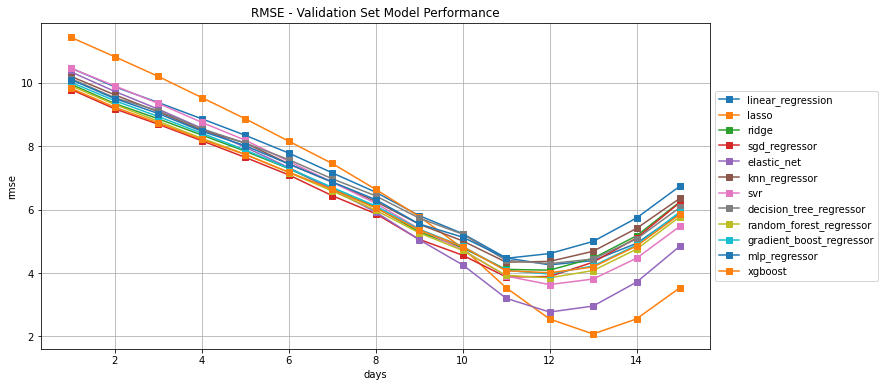

In [37]:
# # plotting results
rcParams['figure.figsize'] = 12, 6

legend_list = ['linear_regression']

ax = valid_rmse_results['linear_regression'].plot(x='days', y='rmse', marker='s', grid=True)

for col in valid_rmse_results.columns[1:]:
    ax = valid_rmse_results[col].plot(x='x', y='rmse', marker='s', grid=True, ax=ax)
    legend_list.append(col)

ax.set_xlabel('days')
ax.set_ylabel('rmse')
ax.set_title('RMSE - Validation Set Model Performance')
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.gcf().set_facecolor('white')

<h5>Predicting with test set</h5>

In [38]:
# preparing test set

# scaling
scaling_set = valid.iloc[-4:].append(test)
scaling_set = scaling_set[scaling_set.columns.drop(list(scaling_set.filter(regex='mean')))
                                             .drop(list(scaling_set.filter(regex='std')))
                                             .drop(list(scaling_set.filter(regex='target')))][cols_to_normalize[:-15]]
mean_set = scaling_set.mean()
# replace any zero value with a really small number to avoid zero division in case close value does not change over N days
std_set = scaling_set.std().replace(0, 0.001)
X_test_scaled = test[cols_to_normalize[:-15]]
X_test_scaled = (X_test_scaled - mean_set) / std_set

# adding the rest of features that were not scaled
temp = test.drop(cols_to_normalize).drop(test.filter(regex='mean').index).drop(test.filter(regex='std').index)
X_test_scaled = X_test_scaled.append(temp)

# reordering the series based on X_train_valid_scaled column order
# reshaping the sample
X_test_scaled = X_test_scaled.reindex(X_train_valid_scaled.columns)
X_test_scaled = X_test_scaled.values.reshape(1, -1)

In [39]:
# predicting the next 15 days with the most optimal models per day
optimal_models_per_day = valid_rmse_results.idxmin(axis=1)

test_results = []
for day in range(1, days_to_predict+1):
    optimal_model = optimal_models_per_day.loc[day]
    model = models[optimal_model].fit(X_train_valid_scaled, y_train_valid_scaled[f'target_SPY_{day}d'])
    
    prediction = model.predict(X_test_scaled)
    prediction = prediction * test[f'SPY_std_{day}d'] + test[f'SPY_mean_{day}d']
    test_results.append(prediction[0])

# test_results

In [40]:
rmse_score = math.sqrt(mean_squared_error(actual_results['target_SPY_1d'], test_results))
print(f'15 day prediction RMSE score: {rmse_score}')

15 day prediction RMSE score: 7.306831360121716


Text(0.5, 1.0, 'Test Predictions')

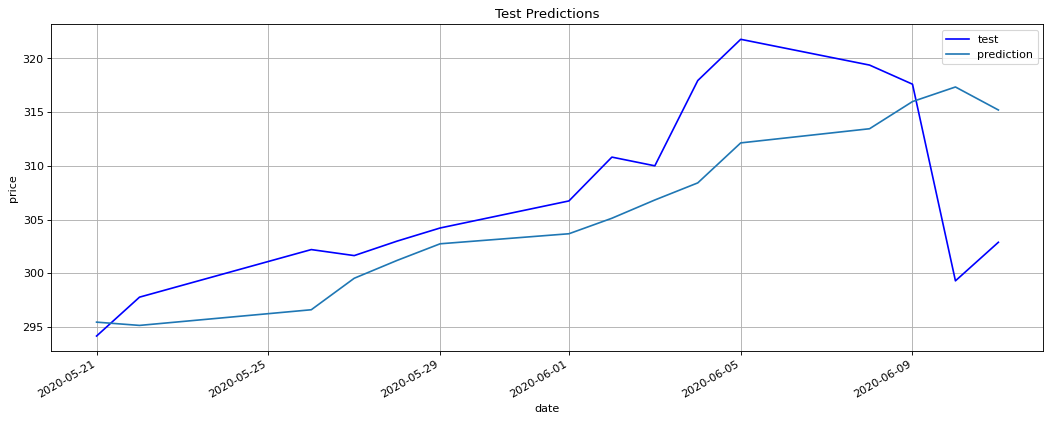

In [41]:
# plot the rmse results and the predictions/actual data
plt.figure(figsize=(16, 6), dpi=80, facecolor='w')

ax = actual_results['target_SPY_1d'].plot(style='b', grid=True)
# ax = test_results.plot(style='r', grid=True, ax=ax)
ax1 = plt.plot(actual_results.index, test_results)

ax.legend(['test', 'prediction'])
ax.set_xlabel('date')
ax.set_ylabel('price')
ax.set_title('Test Predictions')

In [42]:
# set date ranges
# train: 2004-09-29:2017-03-29
# valid: 2017-03-30:2020-05-19
# train_valid: 2004-09-29:2020-05-19
# test: 2020-05-20
# predictions: 2020-05-21:2020-06-11

The results for the final test predictions had an RSME of 7.307.

Looking at the chart above we can see that there is a slight lag in predictions, especially in turns in direction of the market.

I am curious to see what happens if I exclude data after January 31st which was when the 2020 Covid crash started.

For this iteration I switched from obtaining the data from local CSV files to a SQL database after being able to upload all historical data into a personal SQL server. The next step for the data sources is to write and schedule scripts that will web scrape data and upload to the server weekly/monthly.

In this analysis I revised a few features, particularily removing the DIX and GEX index. This contributed to an improvement in RMSE score as now the model has an extra ~10 years worth of data to work with. I was able to get the RMSE score from 4.562 to 4.169 for all data and from 4.012 to 3.434 for pre February 2020 data.

I also added the reg_alpha parameter which was crucial in improving RMSE score from 4.562 to 3.878 for all data and 4.012 to 2.814 for before February 2020 prices. The previous model was definitely overfitting.


The next steps to improving this model:
- predict the next 15/30 days (remember to account for weekends)
- break out each financial feature groups and filter out the low performing ones
- feature engineering (add industry ticker data and volume, % change, etc.)
- explore other scaling methods

To do list:
- write scripts that will continuously upload new data into server
- explore adding options data if possible
- find a way to predict trend data (trend line for week/month out)
- try other prediction models
- try DNN models (tensorflow) 